In [1]:
import pandas as pd
import numpy as np
from matplotlib import colors, cm, text, pyplot as plt
import matplotlib.patches as patches
import sqlite3
from cmcrameri import cm

In [2]:
from sklearn.cluster import DBSCAN

In [3]:
import peakutils
from scipy import signal
import math
import os

In [4]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = -1 * ((1.2 * mz_lower) - 1252)
    scan_for_mz_upper = -1 * ((1.2 * mz_upper) - 1252)
    return (scan_for_mz_lower,scan_for_mz_upper)

In [5]:
# determine the maximum filter length for the number of points
def find_filter_length(number_of_points):
    filter_lengths = [51,11,5]  # must be a positive odd number, greater than the polynomial order, and less than the number of points to be filtered
    return filter_lengths[next(x[0] for x in enumerate(filter_lengths) if x[1] < number_of_points)]

In [6]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'

In [7]:
MZ_MIN = 760
MZ_MAX = 766

In [8]:
charge_one_scan_max = max(scan_coords_for_single_charge_region(mz_lower=MZ_MIN, mz_upper=MZ_MAX))

In [9]:
# constrain the data to re-run the same feature for debugging
MZ_MIN_DEBUG, MZ_MAX_DEBUG = (760.5, 764)
SCAN_MIN_DEBUG, SCAN_MAX_DEBUG = (500, 700)
RT_LOWER_DEBUG, RT_UPPER_DEBUG = (2030, 2033)

In [10]:
PROCESSED_INTENSITY_INDICATOR = -1
INTENSITY_THRESHOLD = 50

In [11]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [12]:
# filter and peak detection parameters
VALLEYS_THRESHOLD_RT = 0.5    # only consider valleys that drop more than this proportion of the normalised maximum
VALLEYS_THRESHOLD_SCAN = 0.5

VALLEYS_MIN_DIST_RT = 2.0     # seconds
VALLEYS_MIN_DIST_SCAN = 10.0  # scans

SCAN_FILTER_POLY_ORDER = 3
RT_FILTER_POLY_ORDER = 3

In [13]:
converted_db_name = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [14]:
db_conn = sqlite3.connect(converted_db_name)
raw_df = pd.read_sql_query("select * from frames where frame_type == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and intensity >= {}".format(FRAME_TYPE_MS1, MZ_MIN_DEBUG, MZ_MAX_DEBUG, SCAN_MIN_DEBUG, SCAN_MAX_DEBUG, RT_LOWER_DEBUG, RT_UPPER_DEBUG, INTENSITY_THRESHOLD), db_conn)
db_conn.close()

In [15]:
# assign each point a unique identifier
raw_df['point_id'] = raw_df.index

In [16]:
CUBOIDS_FILE = '/home/ubuntu/precursor-cuboids-debug.pkl'
precursor_cuboids_l = []
# remove the cuboids file
if os.path.isfile(CUBOIDS_FILE):
    os.remove(CUBOIDS_FILE)
# a unique id for each precursor cuboid
precursor_cuboid_id = 1

#### repeat from here

In [70]:
# find the most intense point
anchor_point_s = raw_df.loc[raw_df.intensity.idxmax()]
anchor_point_s

frame_id               18207.000000
frame_type                 0.000000
mz                       762.604492
scan                     617.000000
intensity                416.000000
retention_time_secs     2030.976810
point_id                1486.000000
Name: 1486, dtype: float64

In [71]:
mz_lower = anchor_point_s.mz - 1.0
mz_upper = anchor_point_s.mz + 7.0
scan_lower = anchor_point_s.scan - 100
scan_upper = anchor_point_s.scan + 100

In [72]:
candidate_region_df = raw_df[(raw_df.frame_id == anchor_point_s.frame_id) & (raw_df.mz >= mz_lower) & (raw_df.mz <= mz_upper) & (raw_df.scan >= scan_lower) & (raw_df.scan <= scan_upper)].copy()


In [73]:
MS1_PEAK_DELTA = 0.1

In [74]:
peak_mz_lower = anchor_point_s.mz-MS1_PEAK_DELTA
peak_mz_upper = anchor_point_s.mz+MS1_PEAK_DELTA

In [75]:
minimum_pixel_intensity = 50
maximum_pixel_intensity = 500

In [76]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=minimum_pixel_intensity, vmax=maximum_pixel_intensity, clip=True)

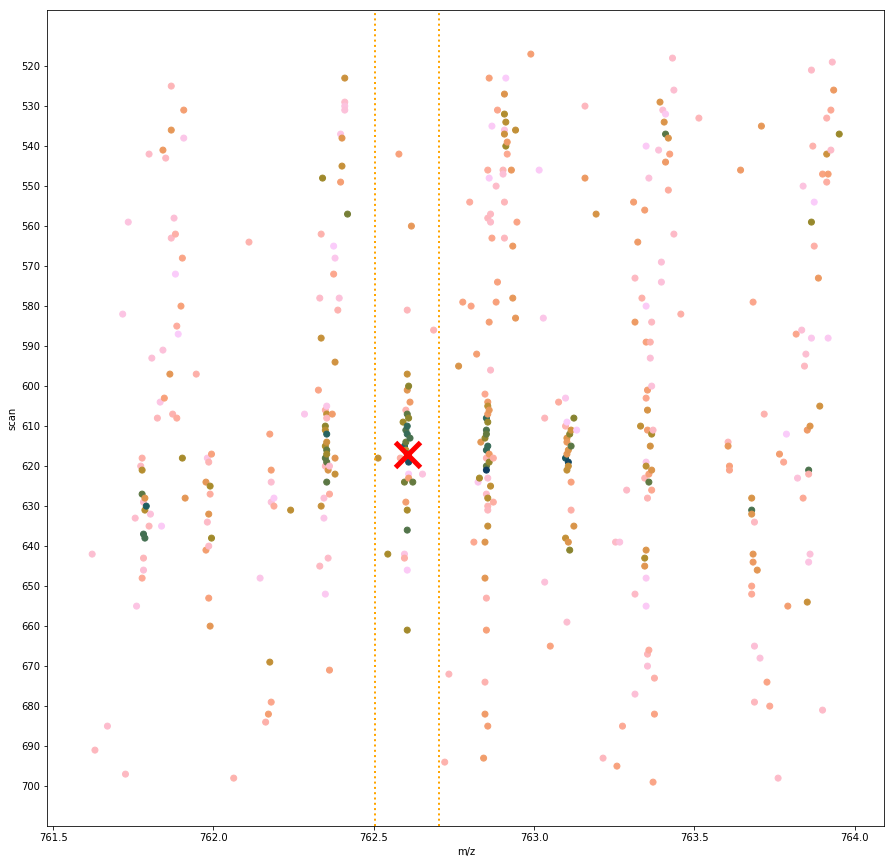

In [77]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(candidate_region_df.mz, candidate_region_df.scan, c=candidate_region_df.intensity, cmap=colour_map, norm=norm)
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point')

plt.axvline(x=peak_mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=peak_mz_upper, linestyle=':', color='orange', linewidth=2)

nearest = 0.5
range_l = round(candidate_region_df.mz.min() / nearest) * nearest
range_u = round(candidate_region_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(candidate_region_df.scan.min() / nearest) * nearest
range_u = round(candidate_region_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [78]:
peak_df = candidate_region_df[(candidate_region_df.mz >= peak_mz_lower) & (candidate_region_df.mz <= peak_mz_upper)]

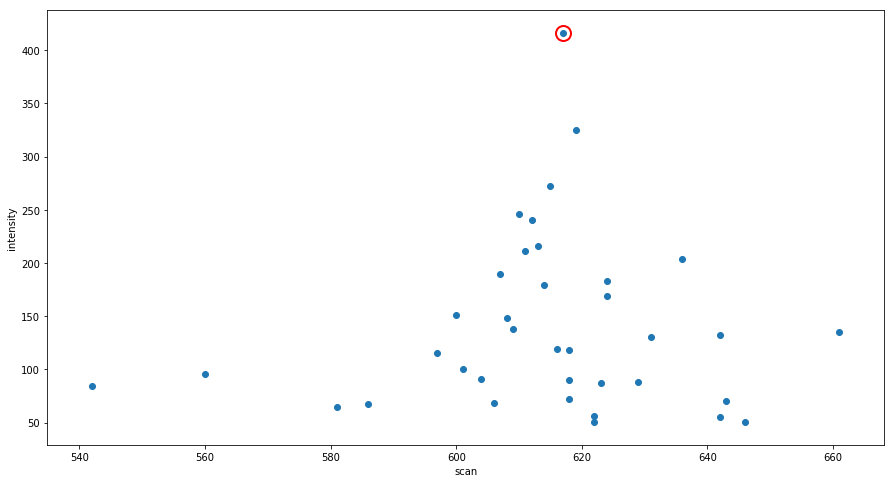

In [79]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(peak_df.scan, peak_df.intensity)
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [80]:
scan_0_df = peak_df.groupby(['scan'], as_index=False).intensity.sum()
scan_0_df.sort_values(by=['scan'], ascending=True, inplace=True)
# filter the points
scan_0_df['filtered_intensity'] = scan_0_df.intensity  # set the default
window_length = 21
if len(scan_0_df) > window_length:
    try:
        scan_0_df['filtered_intensity'] = signal.savgol_filter(scan_0_df.intensity, window_length=find_filter_length(number_of_points=len(scan_0_df)), polyorder=SCAN_FILTER_POLY_ORDER)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [81]:
filtered

True

In [82]:
# find the valleys nearest the anchor point
valley_idxs = peakutils.indexes(-scan_0_df.filtered_intensity.values, thres=VALLEYS_THRESHOLD_SCAN, min_dist=VALLEYS_MIN_DIST_SCAN, thres_abs=False)
valley_x_l = scan_0_df.iloc[valley_idxs].scan.to_list()
valleys_df = scan_0_df[scan_0_df.scan.isin(valley_x_l)]

upper_x = valleys_df[valleys_df.scan > anchor_point_s.scan].scan.min()
if math.isnan(upper_x):
    upper_x = scan_0_df.scan.max()
lower_x = valleys_df[valleys_df.scan < anchor_point_s.scan].scan.max()
if math.isnan(lower_x):
    lower_x = scan_0_df.scan.min()

scan_lower = lower_x
scan_upper = upper_x

In [83]:
valleys_df

,scan,intensity,filtered_intensity
24,624,352,168.680653


In [84]:
scan_0_extract_df = scan_0_df[(scan_0_df.scan >= lower_x) & (scan_0_df.scan <= upper_x)]

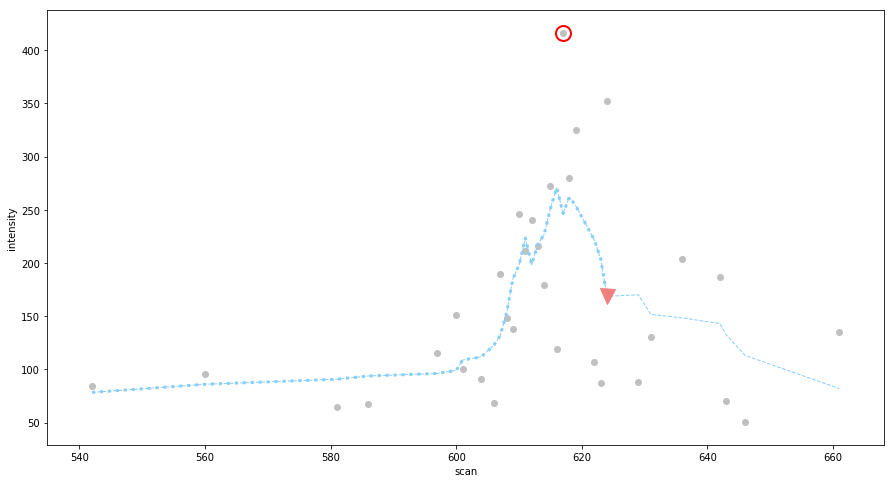

In [85]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_0_df.scan, scan_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(scan_0_extract_df.scan, scan_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.scan, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.plot(anchor_point_s.scan, anchor_point_s.intensity, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15, label='anchor point')

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

#### trim the candidate region to account for the selected peak in mobility

In [86]:
candidate_region_df = candidate_region_df[(candidate_region_df.scan >= lower_x) & (candidate_region_df.scan <= upper_x)]

#### segment the raw data to reveal the isotopes in the feature

In [87]:
X = candidate_region_df[['mz','scan']].values

In [88]:
# a distance metric for points within an isotope
def point_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.1) and (abs(scan_1 - scan_2) <= 5):
        result = 0.5
    else:
        result = 10
    return result

In [89]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=3, metric=point_metric)
clusters = dbscan.fit_predict(X)

In [90]:
candidate_region_df['cluster'] = clusters

In [91]:
candidate_region_df.sample(n=5)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster
2061,18207,0,763.310583,554,87,2030.97681,2061,17
2093,18207,0,763.345246,556,87,2030.97681,2093,17
1233,18207,0,762.348993,606,71,2030.97681,1233,5
1603,18207,0,762.821050,592,87,2030.97681,1603,10
1558,18207,0,762.686780,586,67,2030.97681,1558,-1


In [92]:
number_of_point_clusters = len(candidate_region_df[candidate_region_df.cluster >= 0].cluster.unique())
print('found {} point clusters'.format(number_of_point_clusters))

found 22 point clusters


In [93]:
colour_map = plt.get_cmap('gist_ncar')
norm = colors.Normalize(vmin=candidate_region_df.cluster.min(), vmax=candidate_region_df.cluster.max(), clip=False)

In [94]:
# collect the points that are in the same point cluster as the anchor point
anchor_point_cluster = candidate_region_df[candidate_region_df.point_id == anchor_point_s.point_id].iloc[0].cluster
anchor_point_cluster_points_df = candidate_region_df[candidate_region_df.cluster == anchor_point_cluster]

In [95]:
# calculate the cluster centroids
centroids_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    if group_name >= 0:
        mz_centroid = peakutils.centroid(group_df.mz, group_df.intensity)
        scan_centroid = peakutils.centroid(group_df.scan, group_df.intensity)
        centroids_l.append((group_name, mz_centroid, scan_centroid))
centroids_df = pd.DataFrame(centroids_l, columns=['cluster','mz','scan'])

In [96]:
# determine a colour for each cluster
cluster_colour_l = []
for group_name,group_df in candidate_region_df.groupby(['cluster'], as_index=False):
    c = colour_map(norm(group_name), bytes=False)[:3]
    cluster_colour_l.append((group_name, c))
cluster_colour_df = pd.DataFrame(cluster_colour_l, columns=['cluster','colour'])

In [97]:
# give each point a colour
candidate_region_df = pd.merge(candidate_region_df, cluster_colour_df, how='left', left_on=['cluster'], right_on=['cluster'])


In [98]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour
24,18207,0,761.946345,597,70,2030.97681,1084,1,"(0.0, 0.10646629522482942, 0.6740014539148994)"
71,18207,0,762.591499,609,138,2030.97681,1434,9,"(0.6432103807278832, 1.0, 0.15614114312391633)"
54,18207,0,762.357653,621,105,2030.97681,1290,5,"(0.0, 0.9804, 0.5322025367022871)"


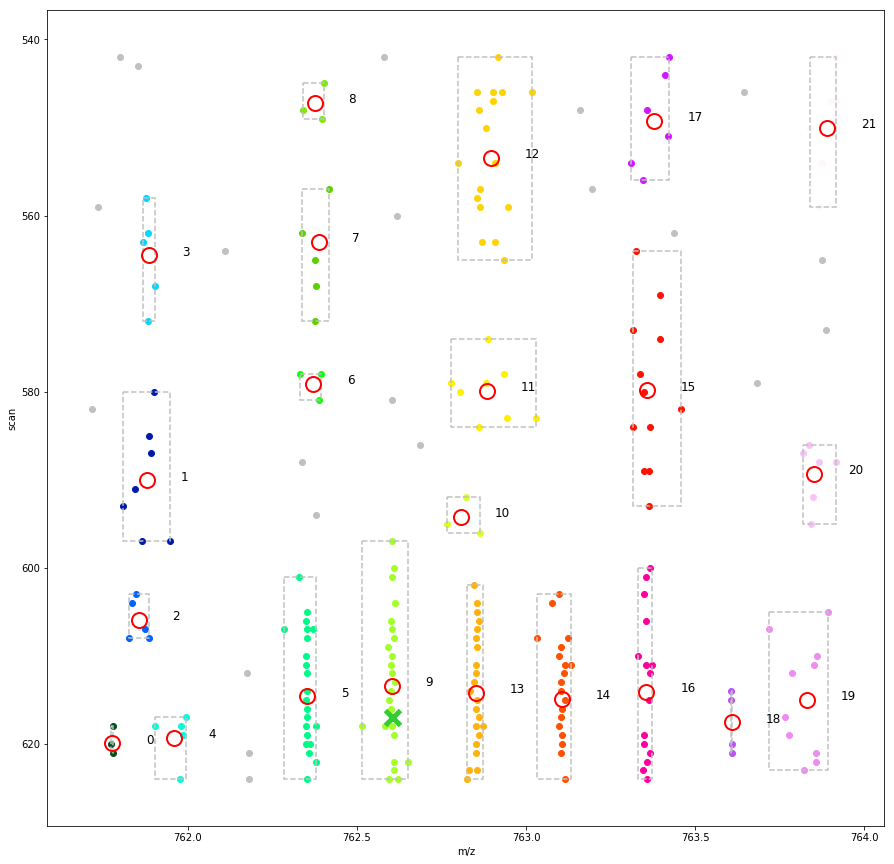

In [99]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

In [100]:
# a distance metric for isotopes within a series
def isotope_metric(r1, r2):
    mz_1 = r1[0]
    scan_1 = r1[1]
    mz_2 = r2[0]
    scan_2 = r2[1]
    if (abs(mz_1 - mz_2) <= 0.8) and (abs(mz_1 - mz_2) > 0.1) and (abs(scan_1 - scan_2) <= 10):
        result = 0.5
    else:
        result = 10
    # print('r1={}, r2={}, result={}'.format(r1,r2,result))
    return result

In [101]:
X = centroids_df[['mz','scan']].values

In [102]:
# cluster the data
dbscan = DBSCAN(eps=1, min_samples=2, metric=isotope_metric)
clusters = dbscan.fit_predict(X)
centroids_df['isotope_cluster'] = clusters

In [103]:
number_of_isotope_clusters = len(centroids_df[centroids_df.isotope_cluster >= 0].isotope_cluster.unique())
print('found {} isotope clusters'.format(number_of_isotope_clusters))

found 3 isotope clusters


In [104]:
candidate_region_df = pd.merge(candidate_region_df, centroids_df[['cluster','isotope_cluster']], how='left', left_on=['cluster'], right_on=['cluster'])


In [105]:
candidate_region_df.fillna(value=-1, inplace=True)
candidate_region_df.isotope_cluster = candidate_region_df.isotope_cluster.astype(int)

In [106]:
candidate_region_df.sample(n=3)

,frame_id,frame_type,mz,scan,intensity,retention_time_secs,point_id,cluster,colour,isotope_cluster
186,18207,0,763.358245,624,189,2030.97681,2169,16,"(1.0, 0.0, 0.6252367084538739)",0
167,18207,0,763.193601,557,106,2030.97681,2017,-1,"(0.0, 0.0, 0.502)",-1
208,18207,0,763.717926,607,68,2030.97681,2410,19,"(0.9319016147635525, 0.5546799307958477, 0.941...",0


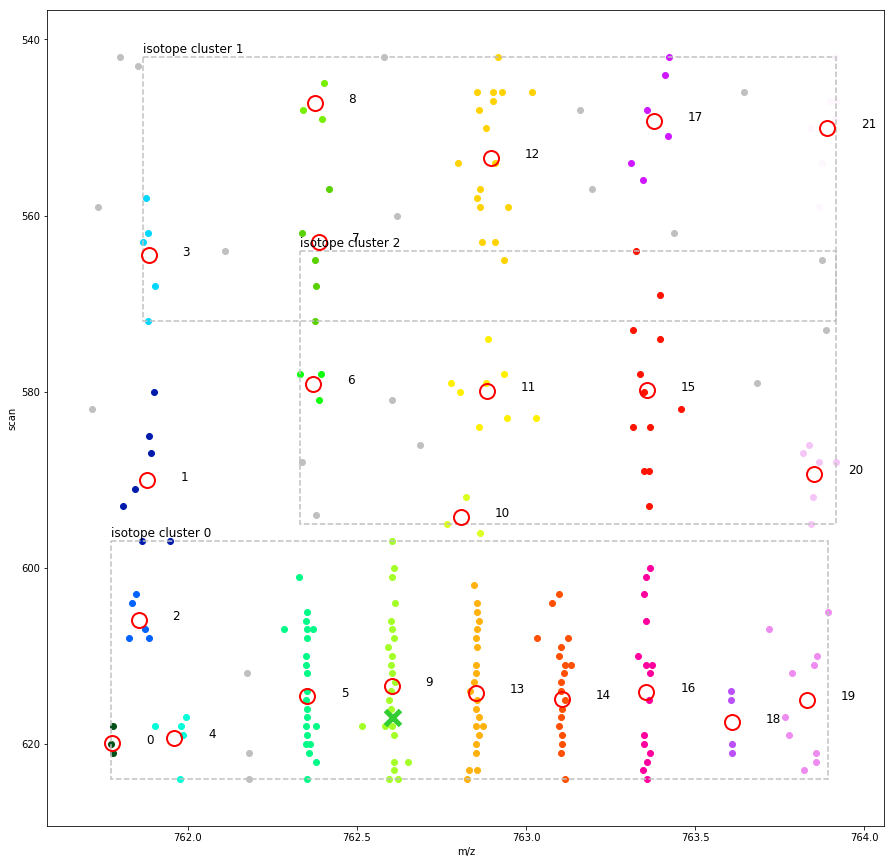

In [107]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

# plot the unassigned points
df = candidate_region_df[(candidate_region_df.cluster == -1)]
plt.scatter(df.mz, df.scan, c='silver')

df = candidate_region_df[(candidate_region_df.cluster >= 0)]
for group_name,group_df in df.groupby(['cluster'], as_index=False):
    # the raw points
    plt.scatter(group_df.mz, group_df.scan, c=np.array([group_df.iloc[0].colour]))
    # the cluster centroid
    centroid_s = centroids_df[(centroids_df.cluster == group_name)].iloc[0]
    plt.plot(centroid_s.mz, centroid_s.scan, marker='o', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=2, ms=15)
    ax1.text(centroid_s.mz+0.1, centroid_s.scan, group_name, fontsize=12)

df = candidate_region_df[(candidate_region_df.isotope_cluster >= 0)]
for group_name,group_df in df.groupby(['isotope_cluster'], as_index=False):
    # draw the cluster rectangle
    top_left = (group_df.mz.min(),group_df.scan.min())
    width = group_df.mz.max() - group_df.mz.min()
    height = group_df.scan.max() - group_df.scan.min()
    cluster_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='silver',facecolor='none')
    ax1.add_patch(cluster_rect)
    ax1.text(top_left[0], top_left[1]-0.5, 'isotope cluster {}'.format(int(group_name)), fontsize=12)

# the anchor point for this candidate region
plt.plot(anchor_point_s.mz, anchor_point_s.scan, marker='x', markerfacecolor='none', markeredgecolor='limegreen', linestyle='', markeredgewidth=5, ms=15, label='anchor point')

plot_xlim = ax1.get_xlim()
plot_ylim = ax1.get_ylim()

plt.xlabel("m/z")
plt.ylabel("scan")
plt.gca().invert_yaxis()
plt.show()

#### we now have the 2D extent of the feature - take that extent through time and see if we can cluster the centroids in time

In [108]:
# which cluster contains the anchor point?
anchor_point_s = candidate_region_df[(candidate_region_df.point_id == anchor_point_s.point_id)].iloc[0]


In [109]:
anchor_point_s

frame_id                                                        18207
frame_type                                                          0
mz                                                            762.604
scan                                                              617
intensity                                                         416
retention_time_secs                                           2030.98
point_id                                                         1486
cluster                                                             9
colour                 (0.6432103807278832, 1.0, 0.15614114312391633)
isotope_cluster                                                     0
Name: 84, dtype: object

In [110]:
# get the extent of the isotope cluster in m/z and mobility
points_in_cluster_df = candidate_region_df[(candidate_region_df.isotope_cluster == anchor_point_s.isotope_cluster)]
mz_lower = points_in_cluster_df.mz.min()
mz_upper = points_in_cluster_df.mz.max()
scan_lower = points_in_cluster_df.scan.min()
scan_upper = points_in_cluster_df.scan.max()

In [111]:
RT_BASE_PEAK_WIDTH = 10

In [112]:
# get the left-most peak in the isotope cluster
monoisotopic_cluster_s = centroids_df.loc[centroids_df[(centroids_df.isotope_cluster == anchor_point_s.isotope_cluster)].mz.idxmin()]


In [113]:
mono_raw_points_df = raw_df[(raw_df.mz >= anchor_point_cluster_points_df.mz.min()) & (raw_df.mz <= anchor_point_cluster_points_df.mz.max()) & (raw_df.scan >= anchor_point_cluster_points_df.scan.min()) & (raw_df.scan <= anchor_point_cluster_points_df.scan.max()) & (raw_df.retention_time_secs >= anchor_point_s.retention_time_secs-RT_BASE_PEAK_WIDTH) & (raw_df.retention_time_secs <= anchor_point_s.retention_time_secs+RT_BASE_PEAK_WIDTH)]
rt_0_df = mono_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_0_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)
# filter the points
rt_0_df['filtered_intensity'] = rt_0_df.intensity  # set the default
window_length = 11
if len(rt_0_df) > window_length:
    try:
        rt_0_df['filtered_intensity'] = signal.savgol_filter(rt_0_df.intensity, window_length=find_filter_length(number_of_points=len(rt_0_df)), polyorder=RT_FILTER_POLY_ORDER)
        filtered = True
    except:
        filtered = False
else:
    filtered = False

In [114]:
filtered

False

In [115]:
len(rt_0_df)

5

In [116]:
peak_idxs = peakutils.indexes(rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/2, thres_abs=False)
peak_x_l = rt_0_df.iloc[peak_idxs].retention_time_secs.to_list()
peaks_df = rt_0_df[rt_0_df.retention_time_secs.isin(peak_x_l)]

In [117]:
valley_idxs = peakutils.indexes(-rt_0_df.filtered_intensity.values, thres=0.05, min_dist=10/8, thres_abs=False)
valley_x_l = rt_0_df.iloc[valley_idxs].retention_time_secs.to_list()
valleys_df = rt_0_df[rt_0_df.retention_time_secs.isin(valley_x_l)]

In [118]:
valleys_df

,frame_id,retention_time_secs,intensity,filtered_intensity


In [119]:
upper_x = valleys_df[valleys_df.retention_time_secs > anchor_point_s.retention_time_secs].retention_time_secs.min()
if math.isnan(upper_x):
    upper_x = rt_0_df.retention_time_secs.max()
lower_x = valleys_df[valleys_df.retention_time_secs < anchor_point_s.retention_time_secs].retention_time_secs.max()
if math.isnan(lower_x):
    lower_x = rt_0_df.retention_time_secs.min()

In [120]:
rt_lower = lower_x
rt_upper = upper_x

In [121]:
rt_0_extract_df = rt_0_df[(rt_0_df.retention_time_secs >= lower_x) & (rt_0_df.retention_time_secs <= upper_x)]

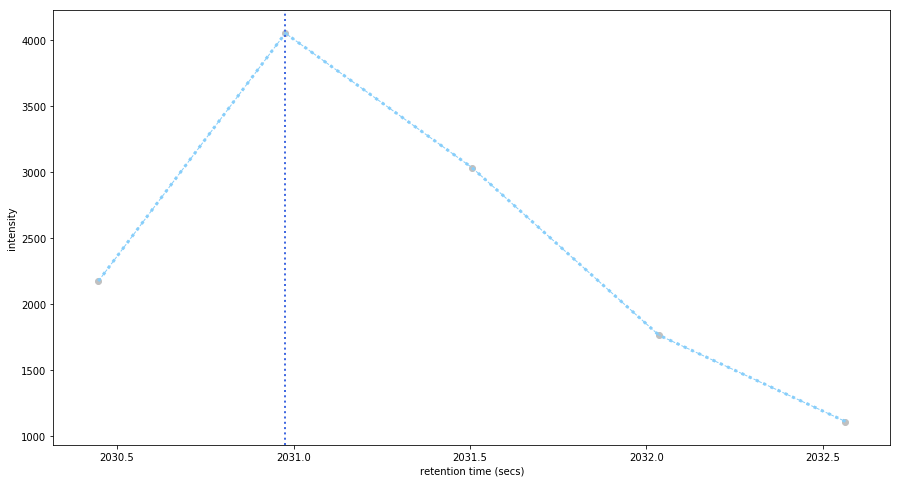

In [122]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_0_df.retention_time_secs, rt_0_df.intensity, c='silver')
# plot the smoothed points
plt.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed')
plt.plot(rt_0_extract_df.retention_time_secs, rt_0_extract_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.plot(valleys_df.retention_time_secs, valleys_df.filtered_intensity, marker='v', color='lightcoral', linestyle=None, linewidth=0, ms=15, label='valleys')
plt.axvline(x=anchor_point_s.retention_time_secs, linestyle=':', color='royalblue', linewidth=2, label='anchor point')

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()